In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
import cv2
import PIL.Image, PIL.ImageTk
import time
import datetime as dt
import argparse


In [3]:
classes = {
    0 : 'angry', 
    1 : 'disgust', 
    2 : 'fear', 
    3 : 'happy', 
    4 : 'neutral', 
    5 : 'sad', 
    6 : 'surprise'
}

In [4]:
curr = os.path.join('datasets/train/train')
directory_contents = os.listdir(curr)
all_data = []
for exp in directory_contents:
    all_images = os.listdir(f'{curr}/{exp}')
    emotion_index = int(list(classes.values()).index(exp))
    data = {'Images' : all_images, 'Label' : emotion_index}
    all_data.append(pd.DataFrame(data))
image_data = pd.concat(all_data, ignore_index=True)
image_data = image_data.sample(frac = 1)
image_data.to_csv(f'datasets/training_images.csv', index=False)

In [5]:
curr = os.path.join('datasets/test/test')
directory_contents = os.listdir(curr)
all_data = []
for exp in directory_contents:
    all_images = os.listdir(f'{curr}/{exp}')
    emotion_index = int(list(classes.values()).index(exp))
    data = {'Images' : all_images, 'Label' : emotion_index}
    all_data.append(pd.DataFrame(data))
image_data = pd.concat(all_data, ignore_index=True)
image_data = image_data.sample(frac = 1)
image_data.to_csv(f'datasets/test_images.csv', index=False)

In [6]:
class CustomImageDataset:
    def __init__(self, csv_file, root_dir, classes, transform=None, target_transform=None) -> None:
        self.annotations = pd.read_csv(f'datasets/{csv_file}')
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = classes
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        label_index = int(self.annotations.iloc[index, 1])
        exp = self.classes[label_index]
        img_path = os.path.join(f'{self.root_dir}/', 
                                        f'{exp}/{self.annotations.iloc[index, 0]}')
        image = read_image(img_path)
        label = torch.tensor(label_index)
        
        if self.transform:
            image = self.transform(image)
        return (image, label)



In [7]:
training_data = CustomImageDataset('training_images.csv', f'{os.getcwd()}/datasets/train/train', classes)
test_data = CustomImageDataset('test_images.csv', f'{os.getcwd()}/datasets/test/test', classes)

In [8]:

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 48, 48])
Labels batch shape: torch.Size([64])


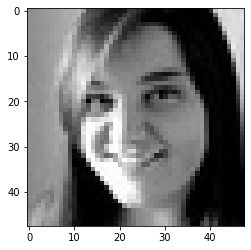

Label: 3 : happy


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} : {classes[int(label)]}")

Lets see some of the random images with the labels

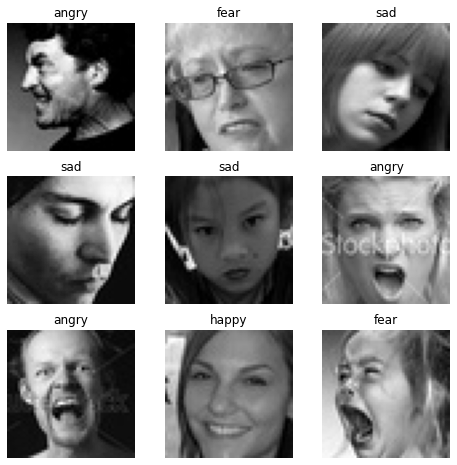

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[int(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Now, we see the distribution of data by different facial expressions

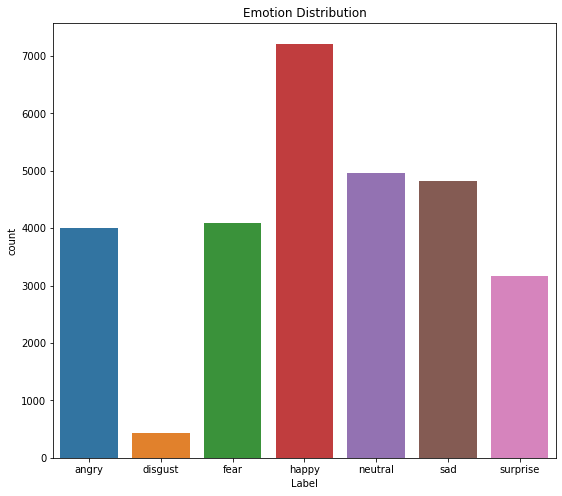

In [11]:
plt.figure(figsize=(9, 8))
ax = sns.countplot(x="Label", data=training_data.annotations)
_ = plt.title('Emotion Distribution')
_ = plt.xticks(ticks=range(0, 7), labels=[classes[i] for i in range(0, 7)], )

Transferring My Model And Data To The GPU Memory

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
device = get_default_device()
device

/home/shubham/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [14]:
train_dl = DeviceDataLoader(train_dataloader, device)
test_dl = DeviceDataLoader(test_dataloader, device)